In [19]:
import pandas as pd
import sys
sys.path.append('utilities')
import helpers as h
import matplotlib.pyplot as plt

# 1: Reading files from disk into memory
start by reading the file locations from file, then load the excel file, list the sheets and load them all into variables. Next load the y_test.csv file.

In [2]:
files = h.get_file_organization(True)

,Key,File Path,Explanation
0,raw_data,c:\Practical Business Python\Year 2\projecten\...,Training dataset in Excel format as downloaded...
1,y_testdata,c:\Practical Business Python\Year 2\projecten\...,Training testdata as downloaded from mail in C...


In [3]:
excel_file = pd.ExcelFile(files['raw_data'])
X_train, X_test, y_train = [pd.read_excel(files['raw_data'], sheet_name= sheet) for sheet in excel_file.sheet_names]
# X_train, X_text, y_train =
y_test = pd.read_csv(files['y_testdata'])
excel_file.close()
assert(len(X_train) == len(y_train))

# 2: EDA - what data do we have?

In [4]:
X_train.head(5)

,work_year,experience_level,employment_type,job_title,employee_residence,work_setting,company_location,company_size
0,2023,Mid-level,Full-time,Machine Learning Engineer,United States,In-person,United States,M
1,2023,Mid-level,Full-time,Data Scientist,United States,In-person,United States,M
2,2024,Senior,Full-time,Data Scientist,United Kingdom,In-person,United Kingdom,M
3,2024,Senior,Full-time,Data Scientist,United States,Remote,United States,M
4,2024,Senior,Full-time,Data Scientist,United Kingdom,Remote,United Kingdom,M


In [5]:
y_train.head(5)

,salary_in_eur
0,188140.00
1,155480.00
2,36800.00
3,88113.92
4,59800.00


## 2.1 single df: 
We want to have a single df with y_train as the target column for easier plotting in our EDA phase. 

In [6]:
df = X_train.copy()
df['target'] = y_train

In [7]:
df.head(5)

,work_year,experience_level,employment_type,job_title,employee_residence,work_setting,company_location,company_size,target
0,2023,Mid-level,Full-time,Machine Learning Engineer,United States,In-person,United States,M,188140.00
1,2023,Mid-level,Full-time,Data Scientist,United States,In-person,United States,M,155480.00
2,2024,Senior,Full-time,Data Scientist,United Kingdom,In-person,United Kingdom,M,36800.00
3,2024,Senior,Full-time,Data Scientist,United States,Remote,United States,M,88113.92
4,2024,Senior,Full-time,Data Scientist,United Kingdom,Remote,United Kingdom,M,59800.00


## 2.2 Column inspection:
What is the range of values we're working with - at a first glance there seem to be quite some columns that might be suitable for ordinal encoding (e.g. company_size or experience_level). But for it to work properly we need to have clearly distinguished values in these columns. (e.g. S,M,L and not S,M,L, 100-1000, 1000-2500 for company_size)

In [8]:
df.nunique()
# we see that there is potential to use ordinal encoding for experience_level and company_size. We might consider employment_type and work_setting too if we can find a meaningful hierarchy there.

work_year                5
experience_level         4
employment_type          4
job_title              145
employee_residence      84
work_setting             3
company_location        73
company_size             3
target                2115
dtype: int64

In [9]:
for column in df.columns:
    if df[column].nunique() < 6:
        print(column, '\t', df[column].unique())

work_year 	 [2023 2024 2022 2020 2021]
experience_level 	 ['Mid-level' 'Senior' 'Entry-level' 'Executive']
employment_type 	 ['Full-time' 'Freelance' 'Contract' 'Part-time']
work_setting 	 ['In-person' 'Remote' 'Hybrid']
company_size 	 ['M' 'L' 'S']


I'm comfortable calling **experience_level** and **company_size** ordinal values and using ordinal encoding on them. There's a clear hierarchy in the unique values printed for these columns. 
I'm less convinced that **employment_type** and **work_setting** shoudl be treated in a similar way. 
- consider *Contract*: is that a full-time or part-time contract? 
- consider *Part-time*: what's the percentage? 
- consider *Hybrid*: What's the ratio between remote and in-person?

At this point we're curious as to why there's so many **company_location**, **job_title** and **employee_residence** values. 
- to be considered: are there **company_locations** that are hyperspecific (e.g. U.S. vs U.S. - Texas)?
- to be considered: are there **job_titles** that are synonyms (e.g. Lead Dev vs Lead developer) or similar (e.g. Docker vs Kubernetes)?

In [10]:
def get_alphabetically(df, column):
    """Takes a pandas DF (df) and a string (column) which is the name of a column in df
    and returns an alphabetical list of values in that column. """
    l = df[column].unique()
    l.sort()
    return l 

def cleanup_strings(df, column, kvdict): 
    """Takes a pandas DF (df), a string (column) which is the name of a column in df 
    and a python dictionary in key(str)-value(str) formwat where key is the value 
    to be replace and value is the stringvalue it should be replaced with"""
    df = df.copy()
    for key, value in kvdict.items():
        df[column] = df[column].str.replace(key, value, regex=True)
    return df

In [ ]:
print(get_alphabetically(df, 'company_location'))
#no, there's no hyperspecificity in countries - but if we use one-hot encoding, we should make it easy for ourselves change the name of some countries
#   - remove ü
#   - all to lowercase
#   - remove spaces
#   - get rid of comma's 

['Algeria' 'American Samoa' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Bahamas' 'Belgium' 'Bosnia and Herzegovina' 'Brazil' 'Canada'
 'Central African Republic' 'China' 'Colombia' 'Croatia' 'Czechia'
 'Denmark' 'Ecuador' 'Egypt' 'Estonia' 'Finland' 'France' 'Germany'
 'Ghana' 'Gibraltar' 'Greece' 'Honduras' 'Hungary' 'India' 'Indonesia'
 'Iran, Islamic Republic of' 'Iraq' 'Ireland' 'Israel' 'Italy' 'Japan'
 'Kenya' 'Korea, Republic of' 'Latvia' 'Lebanon' 'Lithuania' 'Luxembourg'
 'Malaysia' 'Malta' 'Mauritius' 'Mexico' 'Moldova, Republic of'
 'Netherlands' 'New Zealand' 'Nigeria' 'Oman' 'Pakistan' 'Philippines'
 'Poland' 'Portugal' 'Puerto Rico' 'Qatar' 'Romania' 'Russian Federation'
 'Saudi Arabia' 'Singapore' 'Slovenia' 'South Africa' 'Spain' 'Sweden'
 'Switzerland' 'Thailand' 'Türkiye' 'Ukraine' 'United Arab Emirates'
 'United Kingdom' 'United States' 'Viet Nam']


In [12]:
jobs = get_alphabetically(df, 'job_title')
print(jobs, len(jobs))
#Hooray we've opened medusa's box and we found a pile of shit: 
#    'ML Ops Engineer' 'MLOps Engineer' ==> SAME THING
#   there's a bunch of titles that I don't even know what the bloody hell they do - and I'd consider it a miracle of the peeople involved know.

['AI Architect' 'AI Developer' 'AI Engineer' 'AI Product Manager'
 'AI Programmer' 'AI Research Engineer' 'AI Research Scientist'
 'AI Scientist' 'AI Software Engineer' 'Admin & Data Analyst'
 'Analytics Engineer' 'Analytics Engineering Manager'
 'Applied Data Scientist' 'Applied Machine Learning Engineer'
 'Applied Machine Learning Scientist' 'Applied Scientist'
 'Autonomous Vehicle Technician' 'Azure Data Engineer' 'BI Analyst'
 'BI Data Analyst' 'BI Developer' 'Big Data Architect'
 'Big Data Developer' 'Big Data Engineer' 'Business Data Analyst'
 'Business Intelligence' 'Business Intelligence Analyst'
 'Business Intelligence Data Analyst' 'Business Intelligence Developer'
 'Business Intelligence Engineer' 'Business Intelligence Lead'
 'Business Intelligence Manager' 'Business Intelligence Specialist'
 'Cloud Data Architect' 'Cloud Data Engineer' 'Cloud Database Engineer'
 'Compliance Data Analyst' 'Computational Biologist'
 'Computer Vision Engineer' 'Computer Vision Software Engine

In [13]:
print(get_alphabetically(df, 'employee_residence'))

['Algeria' 'American Samoa' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Belgium' 'Bolivia, Plurinational State of' 'Bosnia and Herzegovina'
 'Brazil' 'Bulgaria' 'Canada' 'Central African Republic' 'Chile' 'China'
 'Colombia' 'Costa Rica' 'Croatia' 'Cyprus' 'Czechia' 'Denmark'
 'Dominican Republic' 'Ecuador' 'Egypt' 'Estonia' 'Finland' 'France'
 'Georgia' 'Germany' 'Ghana' 'Greece' 'Honduras' 'Hong Kong' 'India'
 'Indonesia' 'Iran, Islamic Republic of' 'Iraq' 'Ireland' 'Italy' 'Japan'
 'Jersey' 'Kenya' 'Korea, Republic of' 'Kuwait' 'Latvia' 'Lebanon'
 'Lithuania' 'Luxembourg' 'Malaysia' 'Malta' 'Mauritius' 'Mexico'
 'Moldova, Republic of' 'Netherlands' 'New Zealand' 'Nigeria' 'Oman'
 'Pakistan' 'Peru' 'Philippines' 'Poland' 'Portugal' 'Puerto Rico' 'Qatar'
 'Romania' 'Russian Federation' 'Saudi Arabia' 'Serbia' 'Singapore'
 'Slovenia' 'South Africa' 'Spain' 'Sweden' 'Switzerland' 'Thailand'
 'Tunisia' 'Türkiye' 'Uganda' 'Ukraine' 'United Arab Emirates'
 'United Kingdom' 'United States

# 3 data preprocessing: 

In [14]:
#We saw there are more values for employee_residence then there are for company_location. 
# A question we might try to explore: are foreign employees payed less?
df_processed = df.copy()
df_processed['employee_of_country']  = df_processed['employee_residence'] == df_processed['company_location']

In [ ]:
#For jobs we saw that there's some redundancy: same jobs - different spelling. 
# let's address this quickly: (extend as needed)
cleanup_jobs = {
    'Business Intelligence': 'BI',
    'Machine Learning': 'ML',
    'Financial': 'Finance',
    'Modeller': 'Modeler'
    }
df_processed = cleanup_strings(df_processed, 'job_title', cleanup_jobs)

In [ ]:
#Same for country data in employee_residence and company_location
cleanup_countriess = {
    'ü': 'u',
    ',': '',
    ' ': '_'
    }
df_processed = cleanup_strings(df_processed, 'employee_residence', cleanup_countriess)
df_processed = cleanup_strings(df_processed, 'company_location', cleanup_countriess)

# 4: visualisations

## 4.1. do foreign employees earn less?

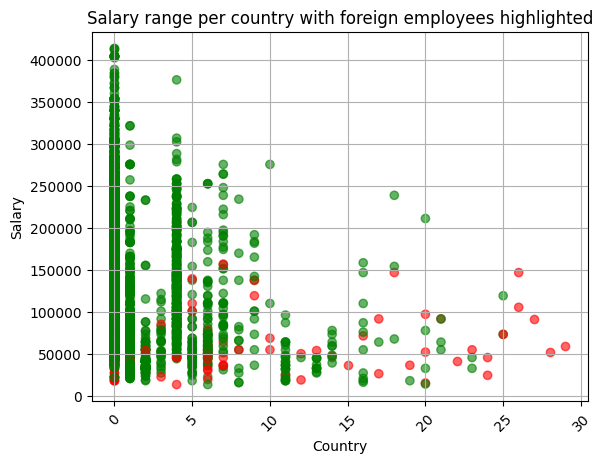

In [29]:
countries_with_false = df_processed[df_processed['employee_of_country'] == False]['company_location'].unique()
df_filtered = df_processed[df_processed['company_location'].isin(countries_with_false)]

for i, country in enumerate(df_filtered['company_location'].unique()):
    country_data = df_filtered[df_filtered['company_location'] == country]
    colors = country_data['employee_of_country'].apply(lambda x: 'green' if x else 'red')
    plt.scatter([i] * len(country_data), country_data['target'], color=colors, alpha=0.6)

# Customize the plot
plt.title('Salary range per country with foreign employees highlighted')
plt.xlabel('Country')
plt.ylabel('Salary')
plt.xticks(rotation=45)
plt.grid(True)